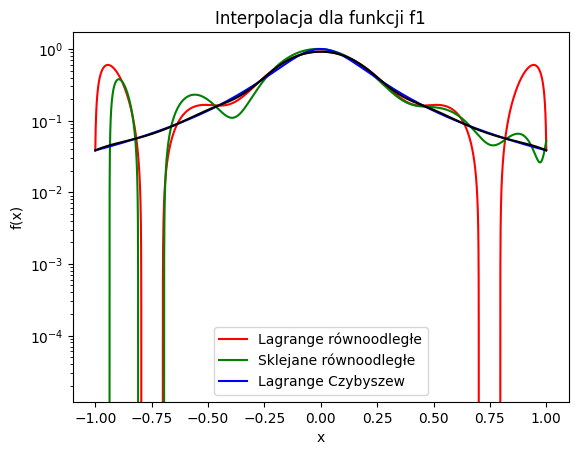

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import mpmath as mp
from random import uniform

def f1(x):
    return 1/(1+25*x*x)

def f2(x):
    return mp.exp(mp.cos(x))

def lagrange_polynomial(x_values, y_values, x):
    sol = 0
    t = 0
    for i in range(0, len(x_values)):
        t = 1
        for j in range(0, len(y_values)):
            if(j != i):
                t = t*((x-x_values[j])/(x_values[i]-x_values[j]))
        sol += t*y_values[i]
    return sol

#transforms chebyshew points to interval [a,b]

def transform_cheb(nodes, a, b):
    for i in range(len(nodes)):
        nodes[i] = a+(b-a)*(nodes[i]+1)/2
    return nodes
#calculates n standard chebyshew points on interval[1,1]
  
def get_nodes_cheb(n):
    nodes = np.empty(shape=n, dtype=float)
    for i in range(n):
        nodes[i] = np.cos(np.pi*(2*i+1)/(2*n+2))
    return nodes

#gets n equidistant nodes in interval [a,b] 

def get_eqdist(n, a, b):
    nodes = np.empty(shape=n, dtype=float)
    h = (b-a)/n
    for i in range(n):
        nodes[i] = a+h*i        
    nodes[n-1] = b
    return nodes


if __name__ == "__main__":

    # x_eq = get_eqdist(12, -1, 1)
    x_eq = np.linspace(-1,1,12)
    y_eq = [f1(x) for x in x_eq]
    x_ch = transform_cheb(get_nodes_cheb(12), -1, 1)
    y_ch = [f1(x) for x in x_ch]
    x_space = np.arange(-1, 1, 1/10000)
    np.append(x_space,1)
    y_eqdist_lag = [lagrange_polynomial(x_eq,y_eq,x) for x in x_space]
    y_cheb_lag = [lagrange_polynomial(x_ch,y_ch,x) for x in x_space]
    plt.semilogy()
    plt.plot(x_space,y_eqdist_lag, color="r", label="Lagrange równoodległe")
    plt.plot(x_space,y_cheb_lag, color="g", label="Sklejane równoodległe")
    plt.plot(x_space,[f1(x) for x in x_space],color="b", label="Lagrange Czybyszew")
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.legend()
    cs = interpolate.CubicSpline(x_eq,y_eq)
    plt.plot(x_space,cs(x_space),color="black")
    plt.title("Interpolacja dla funkcji f1")
    pass

In [4]:
err1 = np.empty(47)
err2 = np.empty(47)
err3 = np.empty(47)
err_eqdist_lag = np.empty(500)
err_cheb_lag = np.empty(500)
err_cs = np.empty(500)
x_set = np.empty(500)
for j in range(500):
    x_set[j] = uniform(0,2*mp.pi)
for i in range(4,51):
    x_eq = get_eqdist(i,0, 2*mp.pi)
    y_eq = [f2(x) for x in x_eq]
    x_ch = transform_cheb(get_nodes_cheb(i), 0, 2*mp.pi)
    y_ch = [f2(x) for x in x_ch]
    y_eqdist_lag = [lagrange_polynomial(x_eq,y_eq,x) for x in x_set]
    y_cheb_lag = [lagrange_polynomial(x_ch,y_ch,x) for x in x_set]
    cs = interpolate.CubicSpline(x_eq,y_eq)
    y_cs = [cs(x) for x in x_set]

    for j in range(500):
        err_eqdist_lag[j] = abs(y_eqdist_lag[j] - f2(x_set[j]))
        err_cheb_lag[j] = abs(y_cheb_lag[j] - f2(x_set[j]))
        err_cs[j] = abs(y_cs[j] - f2(x_set[j]))
    err1[i-4] = np.linalg.norm(err_eqdist_lag)
    err2[i-4] = np.linalg.norm(err_cs)
    err3[i-4] = np.linalg.norm(err_cheb_lag)
plt.semilogy()
plt.scatter([i for i in range(4, 51)], err1, color='r', label="Błąd Lagrange równoodległe")
plt.scatter([i for i in range(4, 51)], err2, color='g', label="Błąd sklejane równoodległe")
plt.scatter([i for i in range(4, 51)], err3, color='b', label="Błąd Lagrange Czybyszew")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Bład funkcji f2")
plt.legend()

KeyboardInterrupt: 

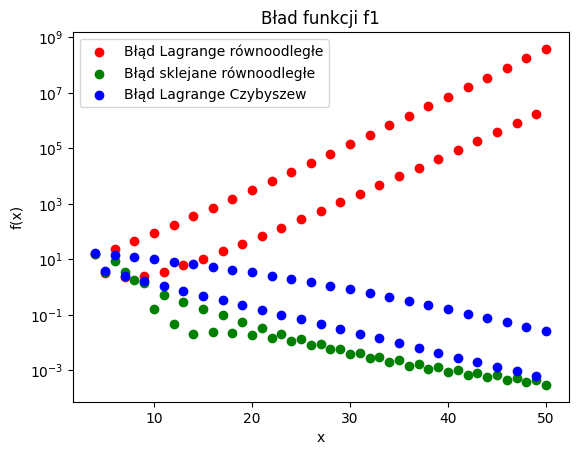

In [ ]:
err1 = np.empty(47)
err2 = np.empty(47)
err3 = np.empty(47)
err_eqdist_lag = np.empty(500)
err_cheb_lag = np.empty(500)
err_cs = np.empty(500)
x_set = np.empty(500)
for j in range(500):
    x_set[j] = uniform(-1,1)
for i in range(4,51):
    x_eq = get_eqdist(i,-1,1)
    y_eq = [f1(x) for x in x_eq]
    x_ch = transform_cheb(get_nodes_cheb(i), -1, 1)
    y_ch = [f1(x) for x in x_ch]
    y_eqdist_lag = [lagrange_polynomial(x_eq,y_eq,x) for x in x_set]
    y_cheb_lag = [lagrange_polynomial(x_ch,y_ch,x) for x in x_set]
    cs = interpolate.CubicSpline(x_eq,y_eq)
    y_cs = [cs(x) for x in x_set]

    for j in range(500):
        err_eqdist_lag[j] = abs(y_eqdist_lag[j] - f1(x_set[j]))
        err_cheb_lag[j] = abs(y_cheb_lag[j] - f1(x_set[j]))
        err_cs[j] = abs(y_cs[j] - f1(x_set[j]))
    err1[i-4] = np.linalg.norm(err_eqdist_lag)
    err2[i-4] = np.linalg.norm(err_cs)
    err3[i-4] = np.linalg.norm(err_cheb_lag)
    
plt.semilogy()
plt.scatter([i for i in range(4, 51)], err1, color='r', label="Błąd Lagrange równoodległe")
plt.scatter([i for i in range(4, 51)], err2, color='g', label="Błąd sklejane równoodległe")
plt.scatter([i for i in range(4, 51)], err3, color='b',label="Błąd Lagrange Czybyszew")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Bład funkcji f1")
plt.legend()